In [156]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
import statsmodels.api as sm

## Part 1: Analyzing Best-Seller Trends Across Product Categories

In [3]:
df = pd.read_csv('csv_files/amz_uk_price_prediction_dataset.csv')

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [ ]:
"""

Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

"""

In [5]:
df_category_bestseller = pd.crosstab(df['category'], df['isBestSeller'])

In [19]:
df_category_bestseller

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [16]:
df_category_bestseller.columns

Index([False, True], dtype='bool', name='isBestSeller')

In [22]:
df_category_bestseller_sorted = df_category_bestseller.sort_values(by= True, ascending=False)

In [23]:
df_category_bestseller_sorted

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


### Chi-square Tests
Tests the independence of two categorical variables by comparing observed frequencies to expected frequencies.

- The chi-square test is a statistical test used to **determine whether there is a significant association between two categorical variables**. 
- Interpretation: if p-value < 0.05, this suggests that there is a significant association between the categorical variables. P-value >= 0.05, indicates that there is not enough evidence to conclude a significant association between the variables. 


In [ ]:
"""

Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category.

"""

In [25]:
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(df_category_bestseller)

chi2_statistic, chi2_p_value

(36540.20270061387, 0.0)

In [ ]:
association(df_category_bestseller, method="cramer")

0.1222829439760564

In [ ]:
"""

Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

"""

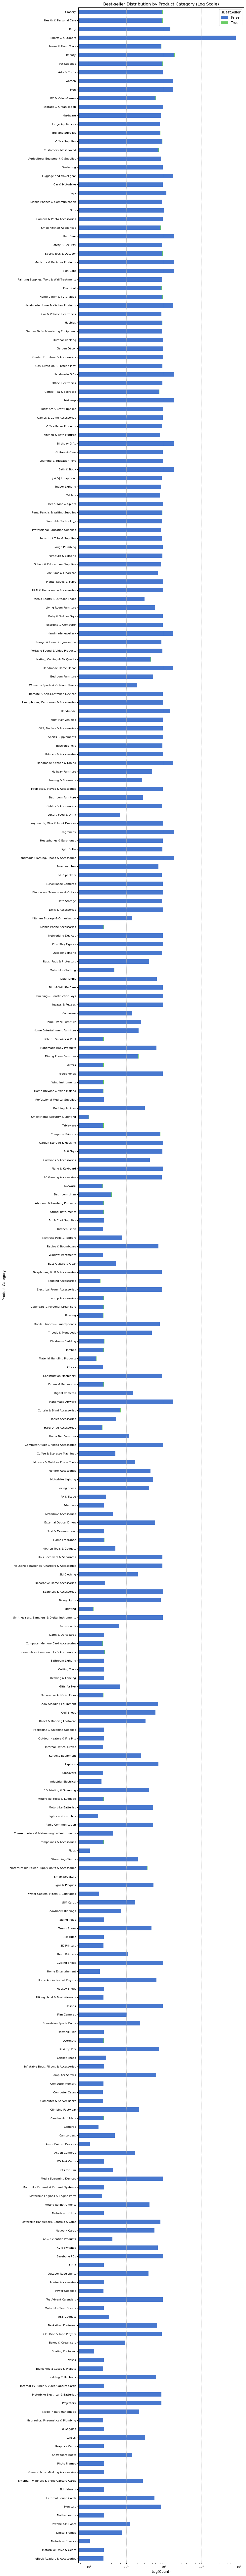

In [ ]:
height = len(df_category_bestseller_sorted) * 0.35

df_category_bestseller_sorted.plot(
    kind='barh',
    stacked=True,
    logx=True,
    figsize=(10, height),
    fontsize=8,
    legend=True
)

plt.title("Best-seller Distribution by Product Category (Log Scale)")
plt.xlabel("Log(Count)")
plt.ylabel("Product Category")
plt.legend(title="isBestSeller", loc='upper right')
plt.grid(True, axis='x', linestyle='--', linewidth=0.5)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

## Part 2: Exploring Product Prices and Ratings Across Categories and Brands

In [ ]:
"""

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. 
Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. 
The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

"""

In [63]:
df_iqr_products = df.copy()

In [64]:
Q1_price = df_iqr_products['price'].quantile(0.25)
Q3_price = df_iqr_products['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

In [65]:
Q1_price, Q3_price, IQR_price

(9.99, 45.99, 36.0)

In [66]:
df_iqr_products.drop(df_iqr_products[(df_iqr_products['price'] < (Q1_price - 1.5 * IQR_price)) | (df_iqr_products['price'] > (Q3_price + 1.5 * IQR_price))].index, inplace=True)


In [67]:
df_iqr_products

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [ ]:
"""

Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.

"""

In [70]:
df_category = df['category']

C:\Users\estif\AppData\Local\Temp\ipykernel_22488\290774245.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y='category', x='price', data=df_top_20_categories, palette='Set2')


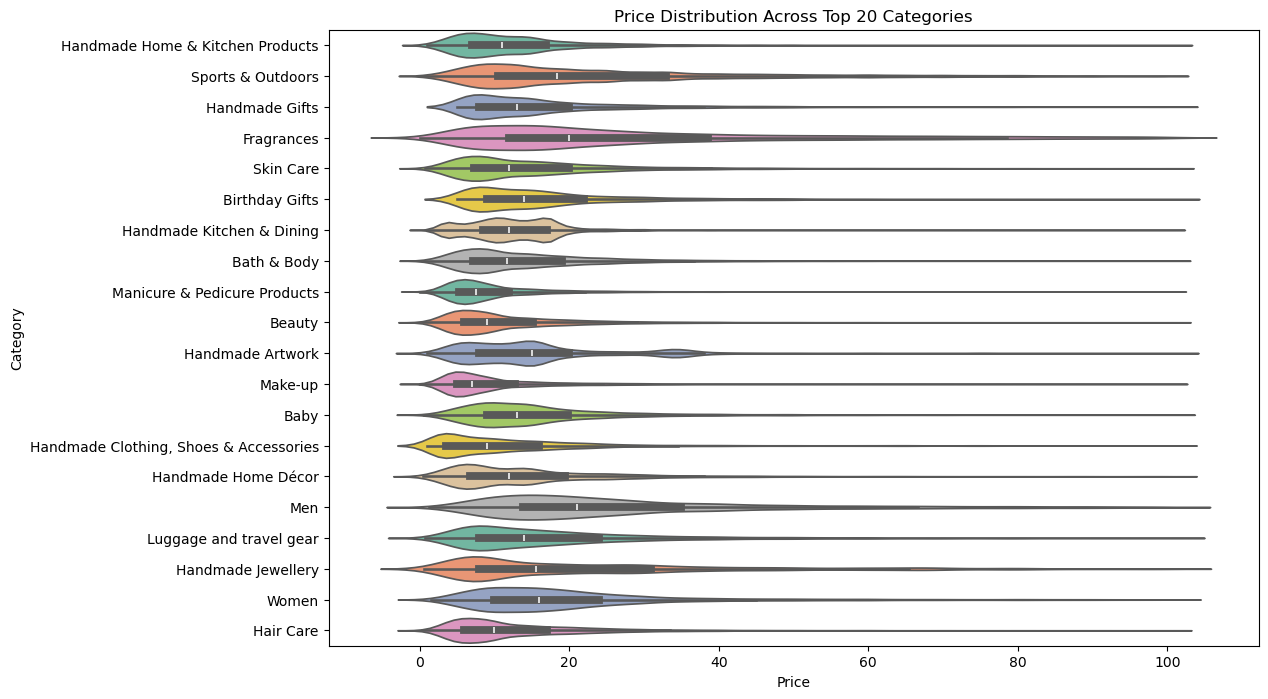

In [ ]:
category_counts = df_iqr_products['category'].value_counts()

top_20_categories = category_counts.head(20).index

df_top_20_categories = df_iqr_products[df_iqr_products['category'].isin(top_20_categories)]

plt.figure(figsize=(12, 8))
sns.violinplot(y='category', x='price', data=df_top_20_categories, palette='Set2')
plt.xlabel('Price') 
plt.ylabel('Category') 
plt.title('Price Distribution Across Top 20 Categories')
plt.show()


In [95]:
df_iqr_product_prices = df_iqr_products[['price', 'category']]

In [ ]:
category_median_price = df_iqr_product_prices.groupby('category')['price'].median()

highest_median_category = category_median_price.idxmax()
highest_median_price = category_median_price.max()


The category with the highest median price is 'Desktop PCs' with a median price of 74.00


In [99]:
category_median_price

category
3D Printers                       52.195
3D Printing & Scanning            28.580
Abrasive & Finishing Products     10.150
Action Cameras                    33.135
Adapters                           7.050
                                   ...  
Wind Instruments                  13.470
Window Treatments                 17.990
Women                             15.990
Women's Sports & Outdoor Shoes    45.990
eBook Readers & Accessories       21.990
Name: price, Length: 296, dtype: float64

In [100]:
highest_median_category

'Desktop PCs'

In [101]:
highest_median_price

74.0

In [ ]:
"""

Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

"""

In [102]:
top_10_categories = category_counts.head(10).index

In [103]:
top_10_categories

Index(['Sports & Outdoors', 'Beauty', 'Bath & Body',
       'Manicure & Pedicure Products',
       'Handmade Clothing, Shoes & Accessories', 'Make-up', 'Skin Care',
       'Hair Care', 'Birthday Gifts', 'Handmade Gifts'],
      dtype='object', name='category')

C:\Users\estif\AppData\Local\Temp\ipykernel_22488\753655644.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='category', x='price', data=avg_price_per_category, palette='Set2')


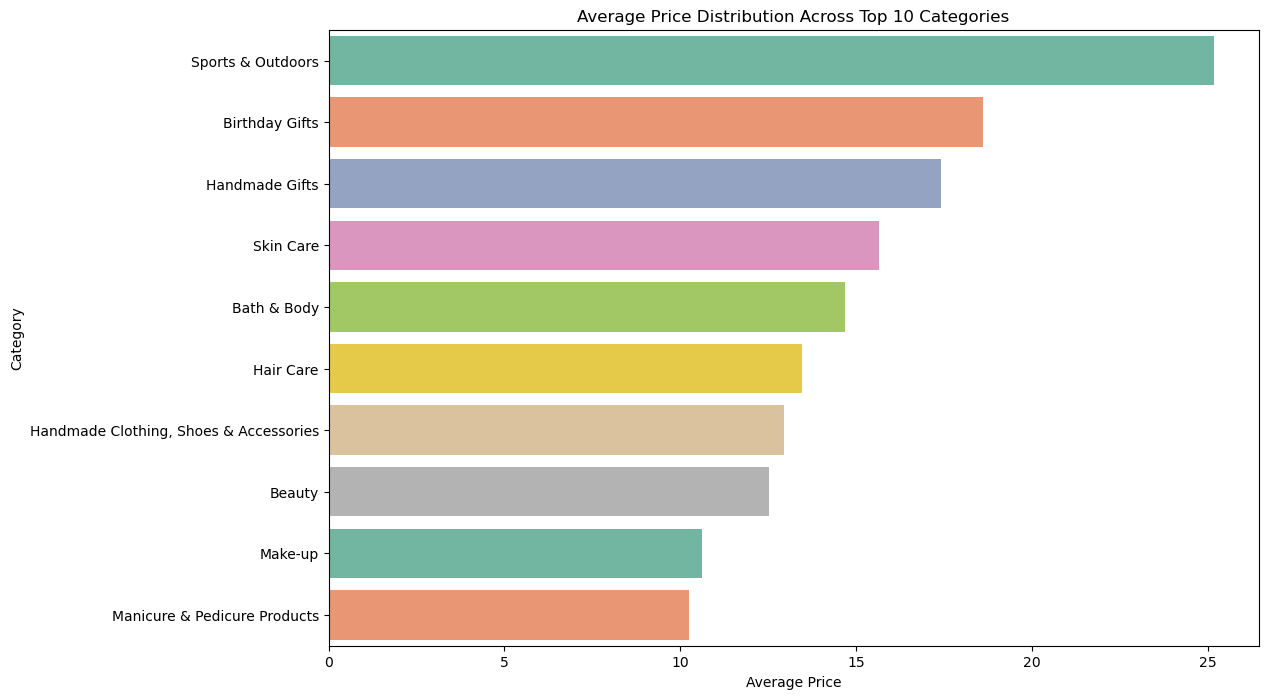

In [110]:
df_top_10_categories = df_iqr_products[df_iqr_products['category'].isin(top_10_categories)]

avg_price_per_category = df_top_10_categories.groupby('category')['price'].mean().reset_index()

avg_price_per_category = avg_price_per_category.sort_values(by='price', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(y='category', x='price', data=avg_price_per_category, palette='Set2')
plt.xlabel('Average Price') 
plt.ylabel('Category') 
plt.title('Average Price Distribution Across Top 10 Categories')
plt.show()

C:\Users\estif\AppData\Local\Temp\ipykernel_22488\152777648.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='category', x='price', data=top_10_avg_price_per_category, palette='Set2')


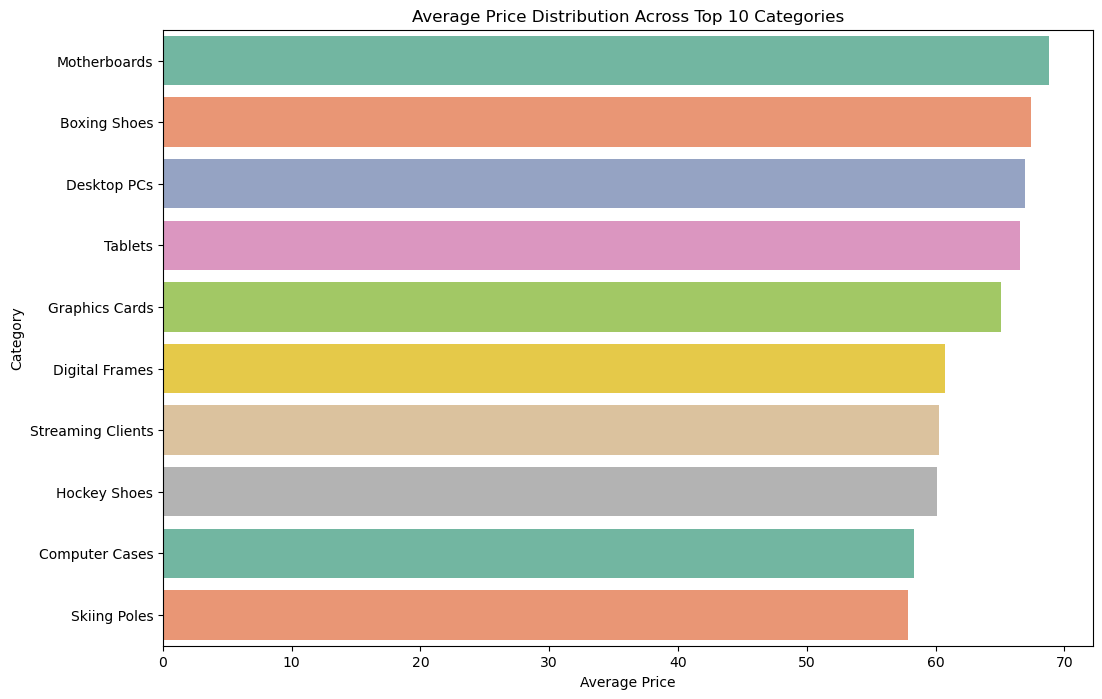

In [117]:
avg_price_per_category = df_iqr_products.groupby('category')['price'].mean().reset_index()

avg_price_per_category = avg_price_per_category.sort_values(by='price', ascending=False)

top_10_avg_price_per_category = avg_price_per_category.head(10)

plt.figure(figsize=(12, 8))
sns.barplot(y='category', x='price', data=top_10_avg_price_per_category, palette='Set2')
plt.xlabel('Average Price') 
plt.ylabel('Category') 
plt.title('Average Price Distribution Across Top 10 Categories')
plt.show()

In [ ]:
"""

Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

"""

In [120]:
df_top_10_categories.groupby('category')['stars'].median()

category
Bath & Body                               4.4
Beauty                                    4.4
Birthday Gifts                            0.0
Hair Care                                 4.4
Handmade Clothing, Shoes & Accessories    0.0
Handmade Gifts                            3.9
Make-up                                   4.2
Manicure & Pedicure Products              4.2
Skin Care                                 4.4
Sports & Outdoors                         0.0
Name: stars, dtype: float64

C:\Users\estif\AppData\Local\Temp\ipykernel_22488\2562558756.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='category', x='stars', data=df_top_10_categories, palette='Set2')


<Axes: xlabel='stars', ylabel='category'>

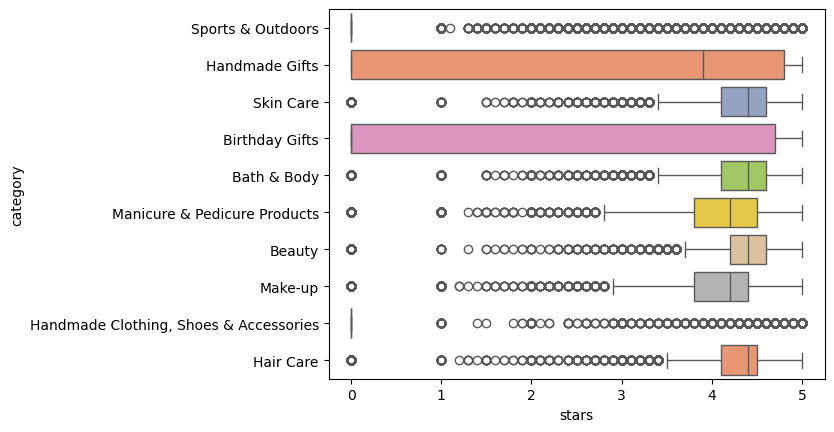

In [122]:
sns.boxplot(y='category', x='stars', data=df_top_10_categories, palette='Set2')

In [123]:
avg_rating_per_category = df_iqr_products.groupby('category')['stars'].median().reset_index()

avg_rating_per_category = avg_rating_per_category.sort_values(by='stars', ascending=False)

top_10_avg_rating_per_category = avg_rating_per_category.head(10)


In [133]:
print(top_10_avg_rating_per_category)

                         category  stars
56                Computer Memory    4.7
36   Building & Construction Toys    4.6
209         Office Paper Products    4.6
174           Luxury Food & Drink    4.6
157            Kids' Play Figures    4.6
132                       Hobbies    4.6
25           Beer, Wine & Spirits    4.6
164            Laptop Accessories    4.6
40           Cables & Accessories    4.5
39                           CPUs    4.5


C:\Users\estif\AppData\Local\Temp\ipykernel_22488\3254762897.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='category', x='stars', data=top_10_avg_rating_per_category, palette='Set2')


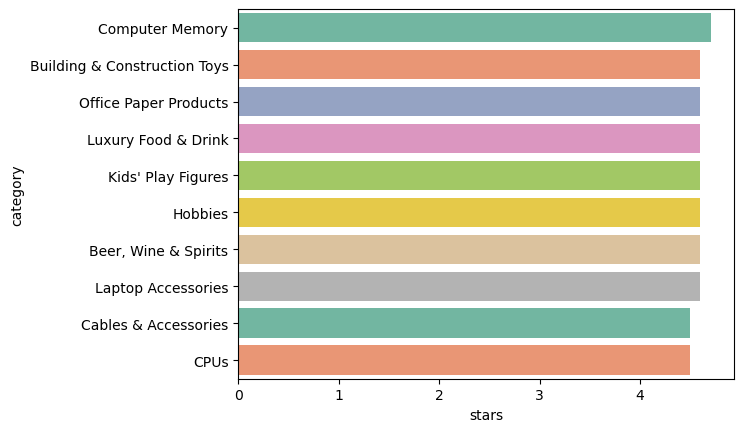

In [132]:
sns.barplot(y='category', x='stars', data=top_10_avg_rating_per_category, palette='Set2')

plt.show()

## Part 3: Investigating the Interplay Between Product Prices and Ratings

In [134]:
"""

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?

"""

'\n\nCorrelation Coefficients:\n\nCalculate the correlation coefficient between price and stars.\nIs there a significant correlation between product price and its rating?\n\n'

In [160]:
correlation = df_iqr_products['price'].corr(df['stars'])
correlation

-0.07767299878181323

In [161]:
correlation = df_iqr_products['price'].corr(df['stars'], method='spearman')
correlation

-0.06679697280768307

In [137]:
# There seems to be a small negative correlation between price and stars, but it is not significant.

In [138]:
"""

Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.

"""

'\n\nVisualizations:\n\nUse a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?\nUse a correlation heatmap to visualize correlations between all numerical variables.\nExamine if product prices typically follow a normal distribution using a QQ plot.\n\n'

<Axes: xlabel='price', ylabel='stars'>

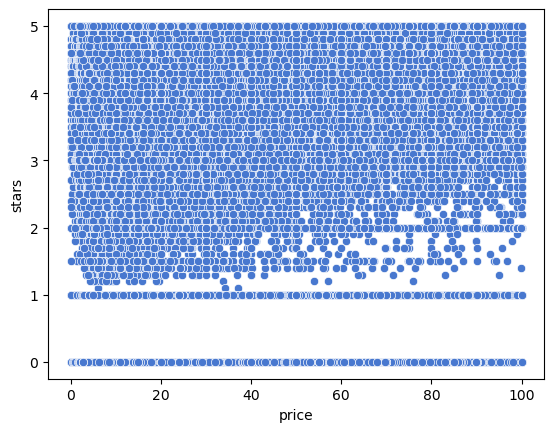

In [162]:
sns.scatterplot(data=df_iqr_products, x='price', y='stars')

In [ ]:
# Observation shows that the products span a wide price range, from nearly 0 to over 20k, with ratings ranging from 0 to 5 stars. 
# There is no clear correlation between price and rating. 
# Products with both low and high ratings can be found across the entire price spectrum, from almost 0 to over 10k, 
#   suggesting that a higher or lower rating does not necessarily correspond to higher or lower prices.

In [163]:
df_numerical = df_iqr_products[['uid', 'stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth']]

In [164]:
df_numerical['isBestSeller'] = df_iqr_products['isBestSeller'].astype(int)

C:\Users\estif\AppData\Local\Temp\ipykernel_22488\812980785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical['isBestSeller'] = df_iqr_products['isBestSeller'].astype(int)


<Axes: >

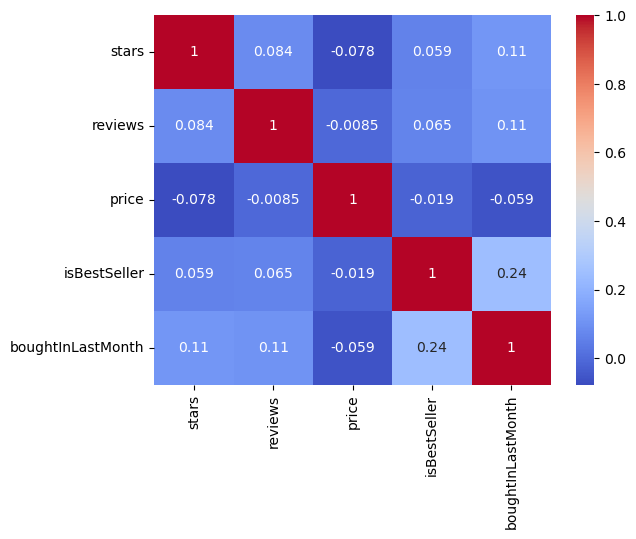

In [165]:
sns.heatmap(df_iqr_products[['stars', 'reviews', 'price', 'isBestSeller', 'boughtInLastMonth']].corr(), annot=True, cmap='coolwarm')

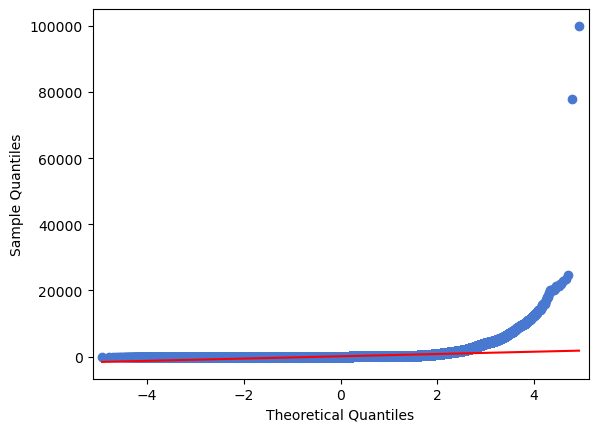

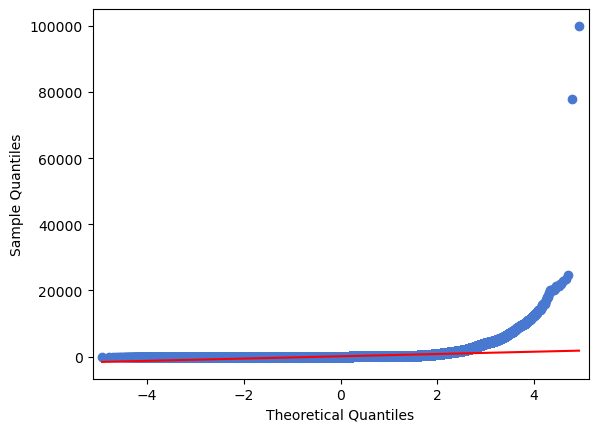

In [ ]:
sm.qqplot(df['price'], line='s')

In [ ]:
"""
The observed 'price' quantiles follow the theoretical normal quantiles more closely at the lower end (roughly the left half of the plot).

"However, at the higher quantiles (the right side of the plot), the sample quantiles deviate significantly upwards from the line representing a normal distribution.

This deviation indicates that the overall distribution of 'price' is skewed to the right (positively skewed) and has a heavier right tail than a normal distribution.

"""

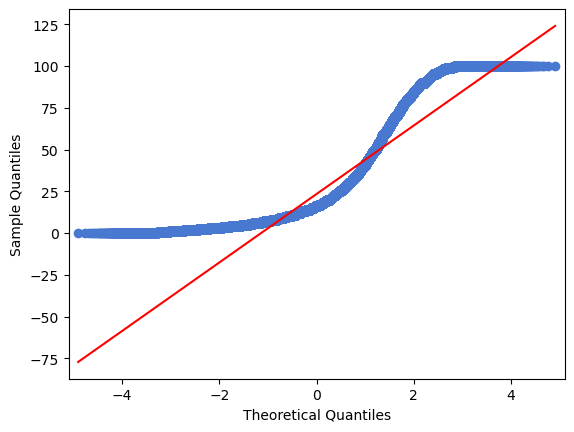

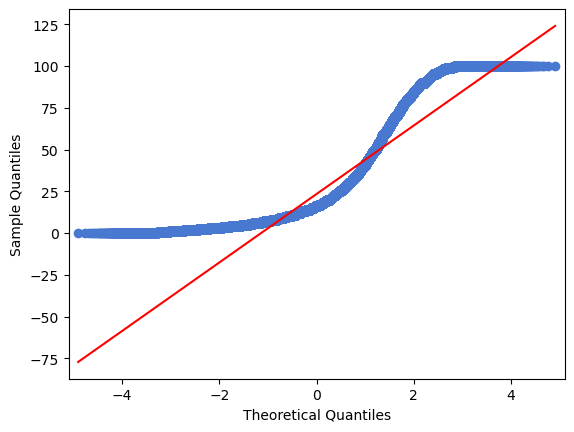

In [158]:
sm.qqplot(df_iqr_products['price'], line='s')

In [ ]:
"""

Observation shows that the 'price' data it represents does not follow a normal distribution. 
The characteristic 'S' shape indicates that the distribution is likely somewhat symmetric but has lighter tails than a normal distribution, 
    meaning fewer extreme high and low values than would be expected under normality.

"""